### Import libraries

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

### Import data

In [2]:
#data retrive from https:lazyprogrammer.me/course_files/airline_passengers.csv
df = pd.read_csv('AirPassengers.csv',index_col = 'Month', parse_dates=True)

In [3]:
df.head()

,#Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


In [4]:
#Checking any missing values
df.isna().sum()

#Passengers    0
dtype: int64

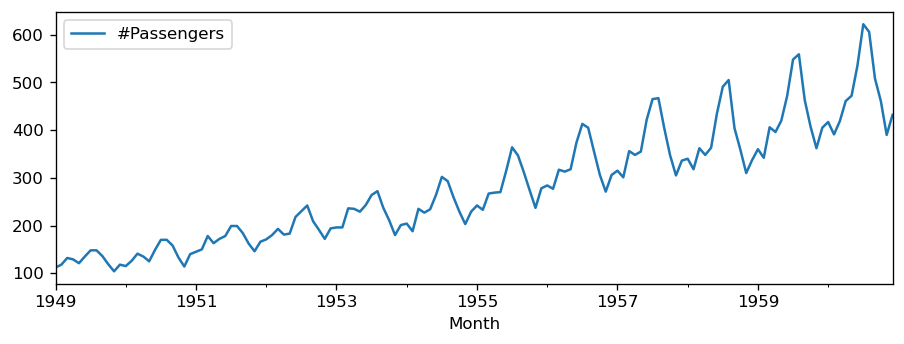

In [5]:
#Plotting the data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df.plot();

We can see that with this data set, there seems to be a trend component and the cyclical component \
trend: means that the signal is generally going upwards \
cyclical: means that there's some periodicity where the same patter repeats itself

In [14]:
#Setting value for alpha. No particular reason to choose 0.2, think of this as a hyper parameter that you can optimize
alpha = 0.2

# EWMA

In [15]:
# If you set adjust = True, it actuallyd oes a different calculation than we we discussed in the lectures
df['EWMA'] = df['#Passengers'].ewm(alpha=alpha, adjust=False).mean()

In [16]:
type(df['#Passengers'].ewm(alpha=alpha, adjust=False))

pandas.core.window.ewm.ExponentialMovingWindow

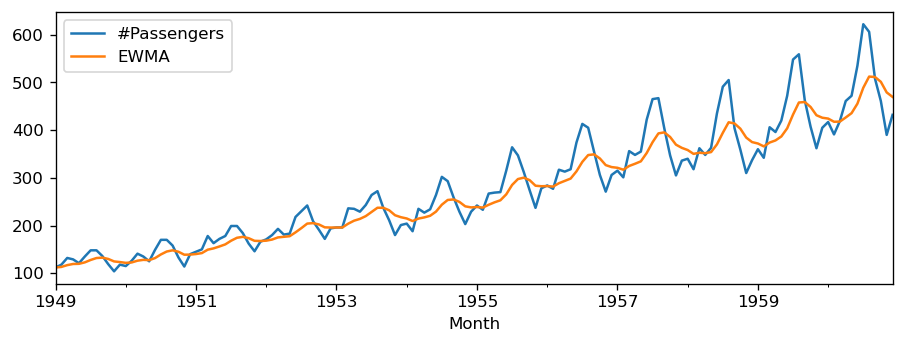

In [17]:
#Plotting the data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df.plot();

Recall formula of EWMA
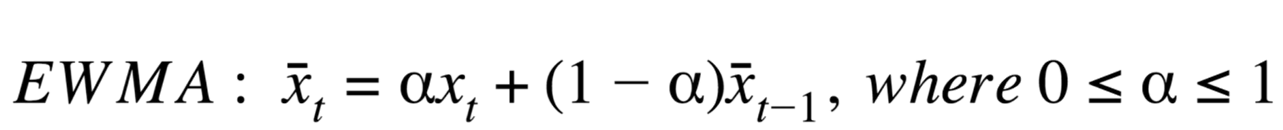

In [19]:
# Manually calculating EWMA
# Remember that EWMA is calculate based on previous value, hence we need to check because if there is no previous value, we cant use the formula

manual_ewma = []
for x in df['#Passengers'].to_numpy():
    if len(manual_ewma) > 0:
        xhat = alpha * x + (1 - alpha) * manual_ewma[-1]
    else:
        xhat = x
    manual_ewma.append(xhat)

In [20]:
df['Manual'] = manual_ewma

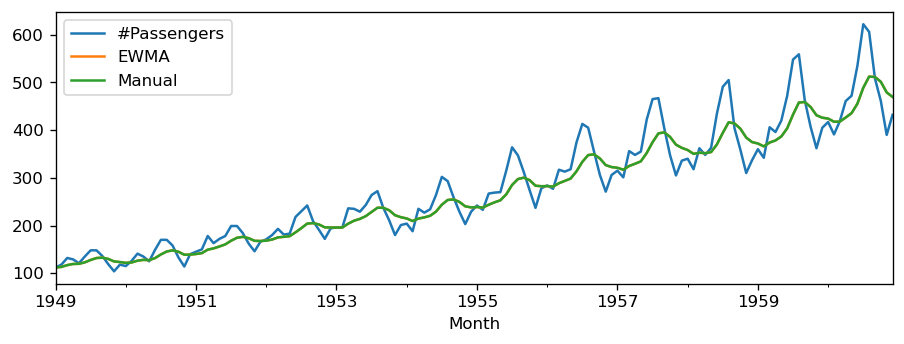

In [22]:
#Plotting the data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df.plot();

Our manual calculation appears to match what Pandas does

In [26]:
df.head()

,#Passengers,EWMA,Manual
Month,,,
1949-01-01,112,112.0000,112.0000
1949-02-01,118,113.2000,113.2000
1949-03-01,132,116.9600,116.9600
1949-04-01,129,119.3680,119.3680
1949-05-01,121,119.6944,119.6944


In [27]:
# Dropping the manual column (redundant)
df.drop('Manual', axis =1, inplace=True)

# SES

In [28]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [29]:
ses = SimpleExpSmoothing(df['#Passengers'])

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


We got warning says "no frequency information was provided, so inferred frequency MS will be used" \
Reason: when we load it in our data frame, Pandas didnt automatically assign a frequency to the index

In [30]:
# link to offset aliases docs
# https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

we can see the freq=None

In [31]:
df.index.freq='MS'

In [32]:
# Instantiate the model
ses = SimpleExpSmoothing(df['#Passengers'], initialization_method='legacy-heuristic')

In [33]:
# Fit the model
res = ses.fit(smoothing_level=alpha, optimized=False)

In [34]:
res

In [35]:
# in-sample (training set) prediction or out-of-sample (testing set) forecast, return an array (pandas series)
res.predict(start=df.index[0], end=df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [38]:
# include the prediction in the dataframe
df['SES'] = res.predict(start=df.index[0], end=df.index[-1])

In [41]:
#Returns True if two arrays are element-wise equal within a tolerance.
np.allclose(df['SES'], res.fittedvalues)

True

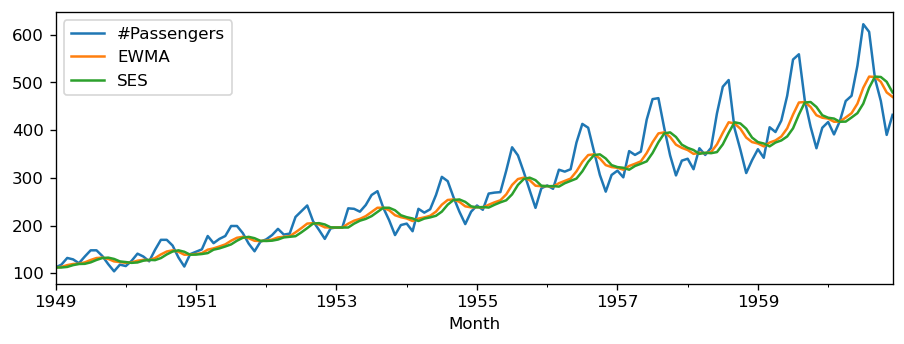

In [40]:
#Plotting the data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df.plot();

The result from our SES model are different from pandas (EWMA). They seem to be shifted up by one

In [42]:
df.head()

,#Passengers,EWMA,SES
Month,,,
1949-01-01,112,112.0000,112.000
1949-02-01,118,113.2000,112.000
1949-03-01,132,116.9600,113.200
1949-04-01,129,119.3680,116.960
1949-05-01,121,119.6944,119.368


In [43]:
# Lets try to shift the SES column back by one to check if the rest of the values line up
df['SES-1'] = df['SES'].shift(-1)

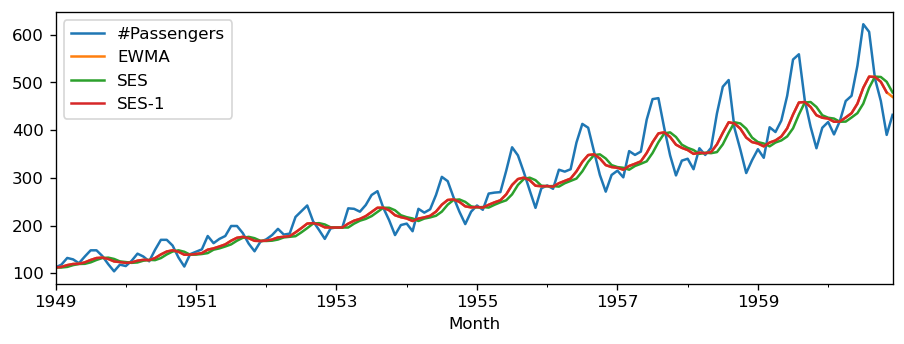

In [44]:
#Plotting the data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df.plot();

As you can see, the values do indeed line up as suspected. However, this is wrong. \
Why this wrong?: Recall that the forecasting model is defined as slightly differently from the traditional EWMA \
The forecasting time index is actually moved up by one step

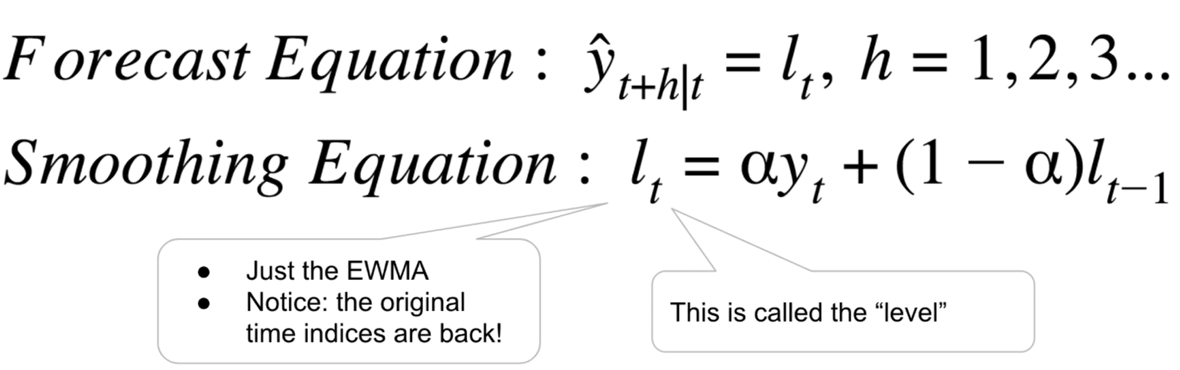

## Treat this as machine learning problem

In [45]:
# Split out the training and testing dataset
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [48]:
# Instantiate the model
ses = SimpleExpSmoothing(train['#Passengers'], initialization_method='legacy-heuristic')
# Fit the model, we didnt set any alpha, the function will now to find the best alpha so that it will minimizes the squared error
res = ses.fit()

In [49]:
# Boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

In [52]:
df.loc[train_idx, 'SESfitted'] = res.fittedvalues
df.loc[test_idx, 'SESfitted'] = res.forecast(N_test)

<AxesSubplot:xlabel='Month'>

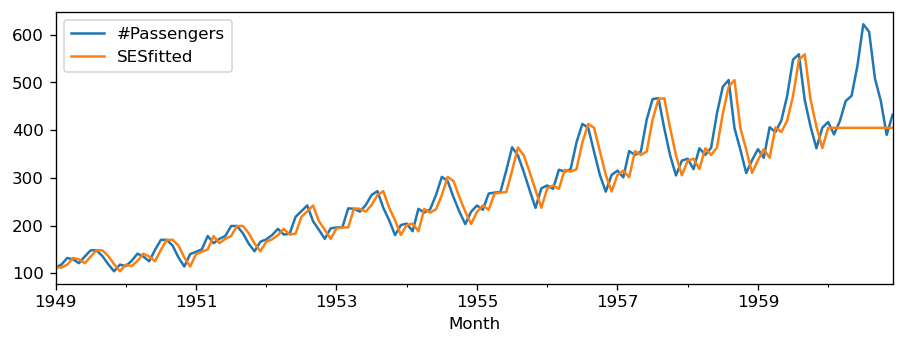

In [53]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df[['#Passengers','SESfitted']].plot()

In [54]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

# Holt Linear Model

In [55]:
from statsmodels.tsa.holtwinters import Holt

In [56]:
# Instantiate the model
holt = Holt(df['#Passengers'], initialization_method='legacy-heuristic' )

In [57]:
res_h = holt.fit()

In [58]:
df['Holt'] = res_h.fittedvalues

<AxesSubplot:xlabel='Month'>

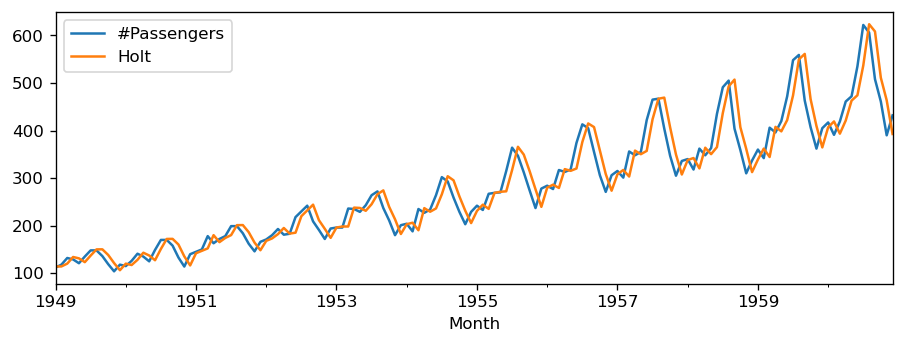

In [59]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df[['#Passengers','Holt']].plot()

In [60]:
df.head()

,#Passengers,EWMA,SES,SES-1,SESfitted,Holt
Month,,,,,,
1949-01-01,112,112.0000,112.000,112.0000,112.000000,114.155500
1949-02-01,118,113.2000,112.000,113.2000,112.000000,114.221156
1949-03-01,132,116.9600,113.200,116.9600,117.970000,120.175837
1949-04-01,129,119.3680,116.960,119.3680,131.929850,134.115056
1949-05-01,121,119.6944,119.368,119.6944,129.014649,131.244976


## Treat this as machine learning problem

In [61]:
# Do exactly the same step as previous except using the train dataset
holt = Holt(train['#Passengers'], initialization_method='legacy-heuristic' )
res_h = holt.fit()
df.loc[train_idx, 'Holt'] = res_h.fittedvalues

In [62]:
df.loc[test_idx, 'Holt'] = res_h.forecast(N_test)

<AxesSubplot:xlabel='Month'>

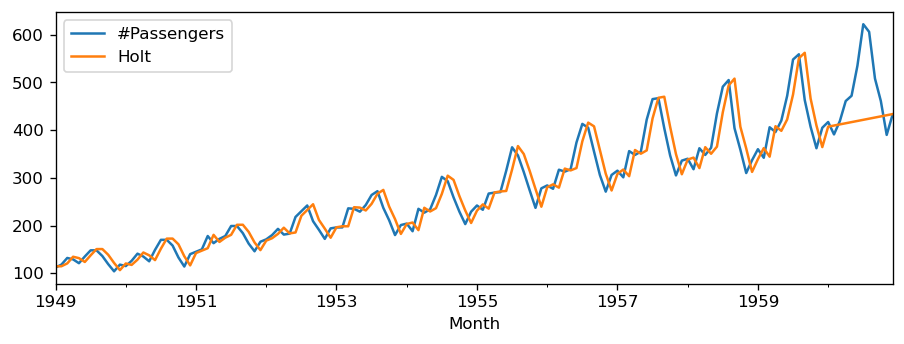

In [63]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df[['#Passengers','Holt']].plot()

# Holt Winters

In [64]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [65]:
# Instantiate the model
hw = ExponentialSmoothing(train['#Passengers'], 
                          initialization_method='legacy-heuristic',
                          trend = 'add',
                          seasonal='add',
                          seasonal_periods=12)

In [67]:
# Fit the model
res_hw = hw.fit()

In [68]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

<AxesSubplot:xlabel='Month'>

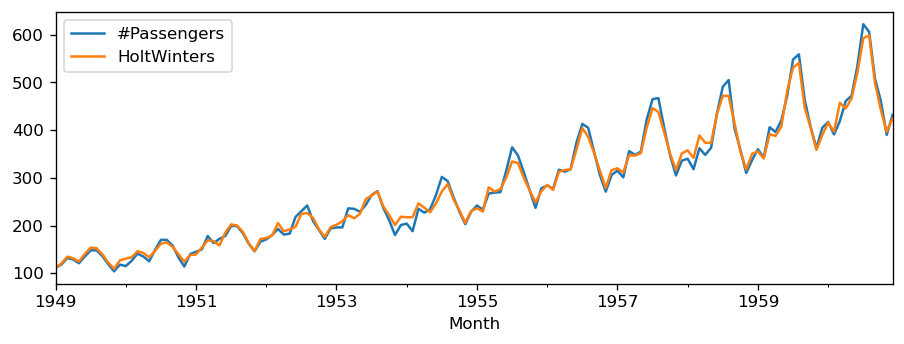

In [69]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df[['#Passengers','HoltWinters']].plot()

## Calculating the forecasting metrics

In [71]:
def rmse(y,t):
    return np.sqrt(np.mean((y-t)**2))

In [72]:
def mae(y,t):
    return np.mean(np.abs(y-t))

In [73]:
print("Train RMSE:", rmse(train['#Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['#Passengers'], res_hw.forecast(N_test)))

Train RMSE: 11.62469954262423
Test RMSE: 16.981141615502576


In [74]:
print("Train MAE:", mae(train['#Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['#Passengers'], res_hw.forecast(N_test)))

Train MAE: 9.011203838180053
Test MAE: 13.382207171715427


## Train using multiplicative seasonal

In [75]:
# Instantiate the model
hw = ExponentialSmoothing(train['#Passengers'], 
                          initialization_method='legacy-heuristic',
                          trend = 'add',
                          seasonal='mul',
                          seasonal_periods=12)

In [76]:
# Fit the model
res_hw = hw.fit()

In [77]:
df.loc[train_idx, 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw.forecast(N_test)

<AxesSubplot:xlabel='Month'>

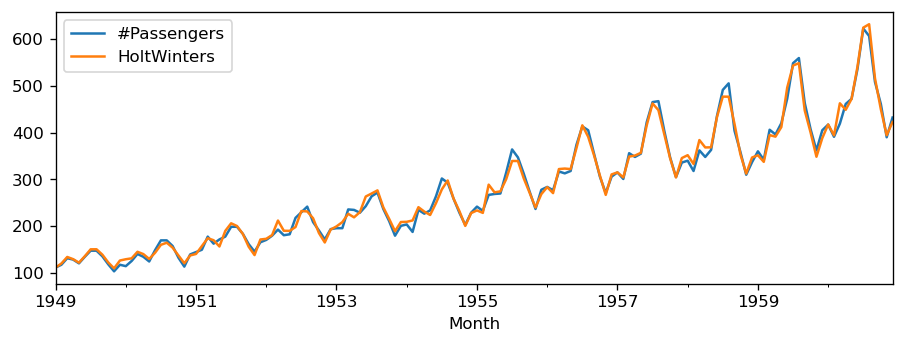

In [78]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df[['#Passengers','HoltWinters']].plot()

In [79]:
print("Train RMSE:", rmse(train['#Passengers'], res_hw.fittedvalues))
print("Test RMSE:", rmse(test['#Passengers'], res_hw.forecast(N_test)))

Train RMSE: 9.768020481856624
Test RMSE: 15.809890178532703


In [80]:
print("Train MAE:", mae(train['#Passengers'], res_hw.fittedvalues))
print("Test MAE:", mae(test['#Passengers'], res_hw.forecast(N_test)))

Train MAE: 7.604221246063918
Test MAE: 10.302594878699557


## Train using both multiplicative for trend & seasonal

In [84]:
# Instantiate the model
hw1 = ExponentialSmoothing(train['#Passengers'], 
                          initialization_method='legacy-heuristic',
                          trend = 'mul',
                          seasonal='mul',
                          seasonal_periods=12)

In [85]:
# Fit the model
res_hw1 = hw1.fit()

C:\Users\asus\anaconda3\lib\site-packages\statsmodels\tsa\holtwinters\model.py:83: RuntimeWarning: overflow encountered in matmul
  return err.T @ err


In [86]:
df.loc[train_idx, 'HoltWinters'] = res_hw1.fittedvalues
df.loc[test_idx, 'HoltWinters'] = res_hw1.forecast(N_test)

<AxesSubplot:xlabel='Month'>

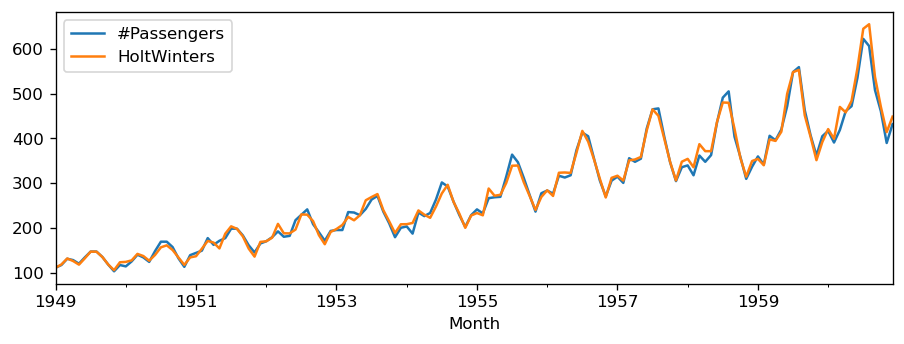

In [87]:
#Plotting the forecast data
plt.rcParams.update({'figure.figsize':(9,3), 'figure.dpi':120})
df[['#Passengers','HoltWinters']].plot()

In [88]:
print("Train RMSE:", rmse(train['#Passengers'], res_hw1.fittedvalues))
print("Test RMSE:", rmse(test['#Passengers'], res_hw1.forecast(N_test)))

Train RMSE: 9.617924831716339
Test RMSE: 25.81135901063159


In [89]:
print("Train MAE:", mae(train['#Passengers'], res_hw1.fittedvalues))
print("Test MAE:", mae(test['#Passengers'], res_hw1.forecast(N_test)))

Train MAE: 7.11238634958478
Test MAE: 20.84917774687902
